In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1HcdISgCl3s4RpWkJa8m-G1JjfKzd8qf2WY2Xcw32D7U/pub?gid=1371955398&single=true&output=csv'

In [3]:
import pandas

historical_record = pandas.read_csv(url)
historical_record['Match Date'] = pandas.to_datetime(historical_record['Match Date'], infer_datetime_format=True)

In [4]:
event_dates = dict(pandas.to_datetime(
    historical_record.groupby('Event').max()['Match Date'],
    infer_datetime_format=True
))

In [5]:
import re
def normalize_name(player):
    return re.sub('[\W_]+', '', player).lower()

all_names = pandas.DataFrame({'Name': historical_record['Player 1'].append(
    historical_record['Player 2']
).unique()})
all_names['Normalized'] = all_names['Name'].apply(normalize_name)

canonical_names = {
    row[0]: row[1]['Name']
    for row in all_names.groupby(['Normalized']).first().iterrows()
}

normalized_names = {
    name: canonical_names[normalize_name(name)]
    for name in all_names['Name']
}

historical_record['Player 1'] = historical_record['Player 1'].apply(lambda n: normalized_names[n])
historical_record['Player 2'] = historical_record['Player 2'].apply(lambda n: normalized_names[n])

In [6]:
historical_record['Event Date'] = historical_record.apply(lambda row: event_dates[row['Event']], axis=1)

In [7]:
standard_format = historical_record[
    historical_record['Format\n(Team)']=='.'
][
    historical_record['Format\n(Restricted)']=='.'
]

/home/cpennington/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [8]:
win_counts = standard_format.groupby([
    'Event Date', 'Event', 'Player 1', 'Player 2'
]).sum().fillna(0)

In [19]:
from skills import Player, Team, Match, Matches
from skills.elo import EloCalculator, EloGameInfo

game_info = EloGameInfo()
calculator = EloCalculator()

ratings = {
    p: 1500
    for p in (historical_record['Player 1'].append(historical_record['Player 2'])).unique()
}

ratings_history = []

games = historical_record.fillna(0).groupby(['Match Date', 'Event', 'Player 1', 'Player 2']).sum().reset_index().sort_values(by=['Match Date'])

for row in games.iterrows():
    p1 = row[1]['Player 1']
    p2 = row[1]['Player 2']
    for _ in range(int(row[1]['Wins 1'])):
        match = Match([[(p1, ratings[p1])], [(p2, ratings[p2])]], [1, 2])
        new_ratings = calculator.new_ratings(match, game_info)
        ratings[p1] = new_ratings.rating_by_id(p1)
        ratings[p2] = new_ratings.rating_by_id(p2)
    for _ in range(int(row[1]['Wins 2'])):
        match = Match([[(p1, ratings[p1])], [(p2, ratings[p2])]], [2, 1])
        new_ratings = calculator.new_ratings(match, game_info)
        ratings[p1] = new_ratings.rating_by_id(p1)
        ratings[p2] = new_ratings.rating_by_id(p2)
    ratings_history.extend([
        (row[1]['Match Date'], row[1]['Event'], p1, new_ratings.rating_by_id(p1) and new_ratings.rating_by_id(p1).mean),
        (row[1]['Match Date'], row[1]['Event'], p2, new_ratings.rating_by_id(p2) and new_ratings.rating_by_id(p2).mean),
    ])
    
ratings_history = pandas.DataFrame(
    ratings_history,
    columns=['Date', 'Event', 'Player', 'Rating']
)

post_tournament_ratings = ratings_history.sort_values(by=['Date', 'Event']).groupby(['Event', 'Player']).last()
ratings_history['Event Date'] = ratings_history.reset_index().apply(lambda row: event_dates[row['Event']], axis=1).values
    

# Top 20 Players by Lifetime Average Elo

In [20]:
ratings_history.groupby('Player').mean().sort_values(by=['Rating'], ascending=False)[:20]

,Rating
Player,
deluks917,1648.053667
Niijima-San,1646.333762
cpat,1640.344667
Raziek,1633.549989
Fivec,1629.849523
ntillerman,1615.615577
drnd,1615.438971
Jengajam,1612.991760
mastrblastr,1606.703170


# Top 20 Players of all time by current rating

In [21]:
ratings_history.sort_values(by=['Date']).groupby('Player').last().sort_values(by=['Rating'], ascending=False)[:20]

,Date,Event,Rating,Event Date
Player,,,,
cpat,2016-09-25,FS.com Into Oblivion,1808.324200,2016-09-25
Fusxfaranto,2017-08-08,IYL Season 5,1702.045473,2017-08-09
Djister,2016-12-01,Rook's Rock n' Rumble,1694.527877,2016-12-01
Legion,2017-06-24,Fractured Factions,1685.733084,2017-06-24
ntillerman,2016-11-26,Topanda League 2,1684.714695,2017-02-17
Niijima-San,2017-07-30,NFTT Round 6,1673.792658,2017-07-30
SirHandsome,2017-08-01,Summer Smash IV,1670.884480,2017-08-07
Nemesis-Kanden,2015-11-08,Triple Threat Throwdown,1656.915434,2016-03-05
Caralad,2017-07-30,Solo Showdown II,1655.416689,2017-07-30


# Top 20 Recently Active Players

In [22]:
import datetime

current_elo = ratings_history.sort_values(by=['Date']).groupby('Player').last()
recent_elo = current_elo[current_elo['Date'] > datetime.date.today() - datetime.timedelta(days=180)]
recent_elo.sort_values(by=['Rating'], ascending=False)[:20]

,Date,Event,Rating,Event Date
Player,,,,
Fusxfaranto,2017-08-08,IYL Season 5,1702.045473,2017-08-09
Legion,2017-06-24,Fractured Factions,1685.733084,2017-06-24
Niijima-San,2017-07-30,NFTT Round 6,1673.792658,2017-07-30
SirHandsome,2017-08-01,Summer Smash IV,1670.884480,2017-08-07
Caralad,2017-07-30,Solo Showdown II,1655.416689,2017-07-30
BD Corro,2017-08-05,IYL Season 5,1654.928403,2017-08-09
deluks917,2017-04-29,NFTT Round 3,1644.428898,2017-04-29
Leontes,2017-08-07,IYL Season 5,1640.243302,2017-08-09
flagrantangles,2017-08-02,Summer Smash IV,1638.267931,2017-08-07


# Rating Trajectories of all Players over All Time

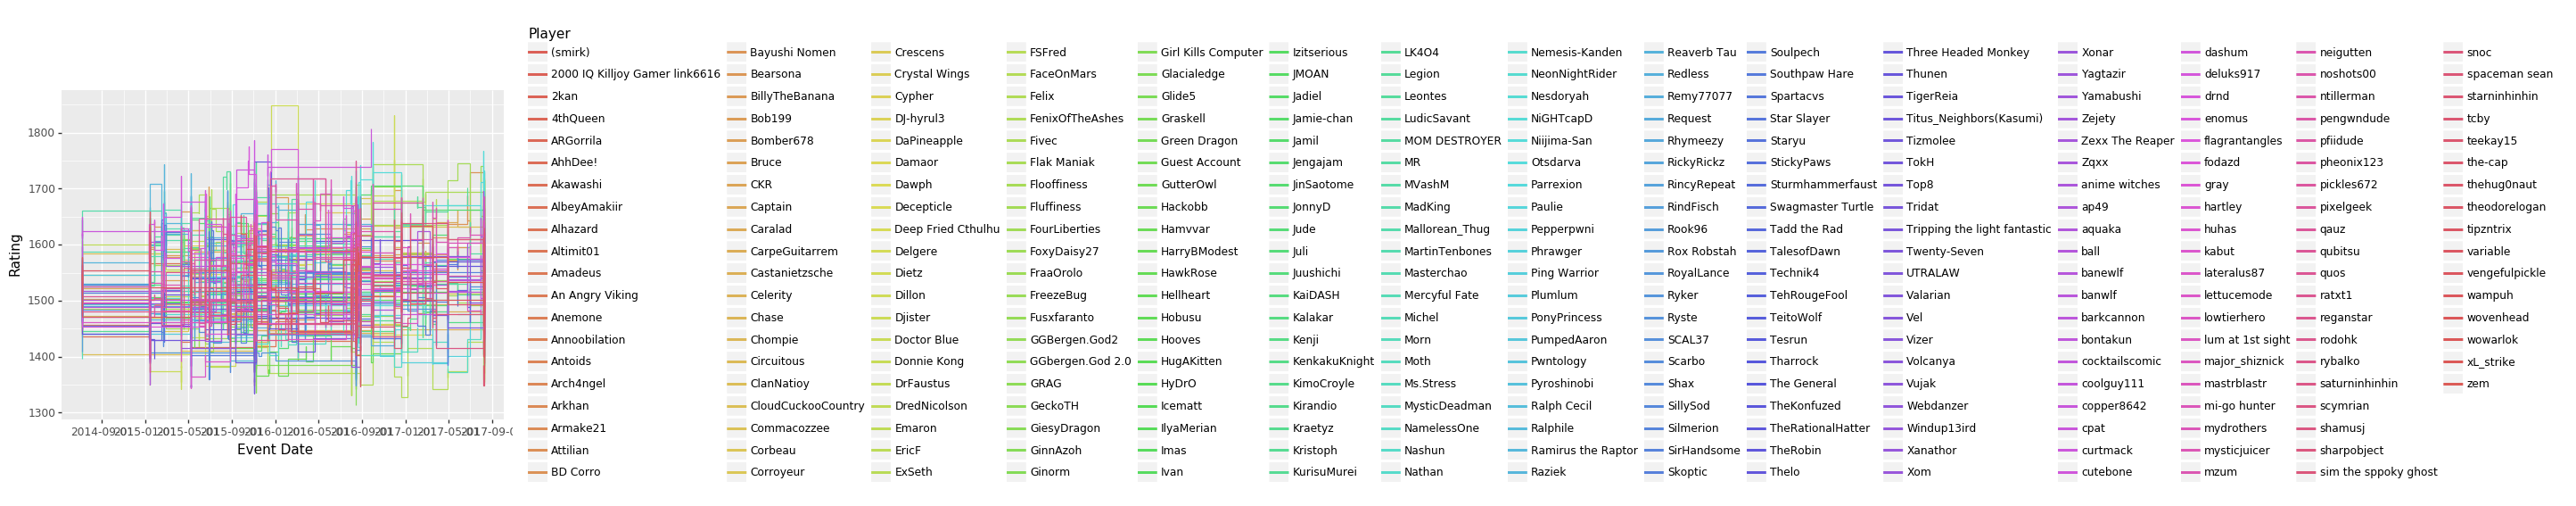

<ggplot: (8774340248766)>

In [23]:
from plotnine import *

ggplot(
    ratings_history.reset_index(),
    aes(
        x='Event Date',
        y='Rating',
        color='Player',
    )
) + geom_step()